In [2]:
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import getenv
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

_ =load_dotenv(override=True)

In [3]:
url = f"postgresql://postgres:{getenv('SUPABASE_PWD')}@{getenv('SUPABASE_URL')}:5432/postgres"
engine = create_engine(url)

### Dump Client and Household tables for Analysis
Dumping for storage in S3 where it will be used in Athena

In [5]:
clients = pd.read_sql("SELECT id, title FROM public.clients", engine)
clients.to_csv('../data/clients.csv', index=False)

In [90]:
households_query = f"""SELECT 
ph.id, ph.activation_code, ph.account_status, ph.client_id, c.title as client_title, cg.name as client_group, ph.date_of_activation, ph.gas_ean, ph.electricity_ean, 
phd.build_year, phd.square_meters, phd.house_type, phd.heating_type, phd.gas_connection, phd.gas_or_induction, phd.water_heating_type, 
hd.zipcode, hd.house_number, hd.house_number_addition, hd.housing_corporation
FROM public.households ph 
LEFT JOIN public.clients c ON c.id = ph.client_id
LEFT JOIN public.household_house_details phd ON phd.household_id = ph.id 
LEFT JOIN public.household_details hd ON hd.household_id = ph.id 
LEFT JOIN public.client_groups cg ON cg.id = ph.client_group_id
"""

households = pd.read_sql(households_query, engine)

In [74]:
alle_adressen = pd.read_csv('../data/alle_adressen_output.csv', sep=';', low_memory=False, encoding='utf-8')

In [91]:
# Removing households without a house_number to allow parsing to integer
# This removes ±73 records of which ±24 Active but of those only 2 are not connected to 'TestClient'
households = households[~pd.isna(households['house_number'])]
households['house_number'] = households['house_number'].astype('int')

In [92]:
households['address'] = households['zipcode'] + households['house_number'].astype(str)
alle_adressen['address'] = alle_adressen['Postcode'] + alle_adressen['Huisnummer'].astype(str)
alle_adressen.drop_duplicates(subset='address', inplace=True)
households = households.merge(alle_adressen[['address', 'lon', 'lat']], on='address', how='left').drop(columns='address')

In [ ]:
households['date_of_activation'] = households['date_of_activation'].dt.date.astype(str)
households['id'] = households['id'].astype(str)
households['client_id'] = households['client_id'].astype(str)

In [118]:
households.to_json('../data/households_for_analysis.json', orient='records', lines=True, default_handler=str)

### Households

In [8]:
HL = '6a4e7955-aca0-4dab-8a13-0a6adb014b57'

households_query = f"""SELECT 
ph.id, ph.activation_code, ph.account_status, ph.client_id, ph.date_of_activation, ph.gas_ean, ph.electricity_ean, 
phd.build_year, phd.square_meters, phd.house_type, phd.heating_type, phd.gas_connection, phd.gas_or_induction, phd.water_heating_type, 
hd.zipcode, hd.house_number, hd.house_number_addition, hd.housing_corporation, cg.name as client_group
FROM public.households ph 
LEFT JOIN public.household_house_details phd ON phd.household_id = ph.id 
LEFT JOIN public.household_details hd ON hd.household_id = ph.id 
LEFT JOIN public.client_groups cg ON cg.id = ph.client_group_id
WHERE ph.client_id = '{HL}'
"""

In [4]:
households = pd.read_sql(households_query, engine)

In [5]:
households.head(2)

,id,activation_code,account_status,client_id,date_of_activation,gas_ean,electricity_ean,build_year,square_meters,house_type,heating_type,gas_connection,gas_or_induction,water_heating_type,zipcode,house_number,house_number_addition,housing_corporation,client_group
0,da3bc575-a364-42cd-be06-1d4d6407fc89,UXSEDVH,Active,6a4e7955-aca0-4dab-8a13-0a6adb014b57,2023-01-10 00:00:00+00:00,871717730000094431,871687940008642729,NaN,NaN,apartment,None,None,None,None,5591TP,14.0,,Koop,Heeze-West
1,f448318f-e7e0-4424-9ab1-b44e0c354882,5TWMYPF,Active,6a4e7955-aca0-4dab-8a13-0a6adb014b57,2022-12-24 00:00:00+00:00,871717730000067626,871687940031384184,NaN,NaN,apartment,None,None,None,None,5595CD,13.0,,Koop,Leende


In [6]:
households.columns

Index(['id', 'activation_code', 'account_status', 'client_id',
       'date_of_activation', 'gas_ean', 'electricity_ean', 'build_year',
       'square_meters', 'house_type', 'heating_type', 'gas_connection',
       'gas_or_induction', 'water_heating_type', 'zipcode', 'house_number',
       'house_number_addition', 'housing_corporation', 'client_group'],
      dtype='object')

In [7]:
print(f"Total number of households: {len(households)}")
print(f"Are all unique records?: {len(households) == len(households.drop_duplicates(subset='id'))}")

Total number of households: 6902
Are all unique records?: True


### Enrich

In [8]:
def build_years(row: pd.Series) -> pd.Series:
    bouwjaar = None
    if row["build_year"] < 1950:
        bouwjaar = "tot 1950"
    elif 1950 <= row["build_year"] < 1975:
        bouwjaar = "1950-1975"
    elif 1975 <= row["build_year"] < 1992:
        bouwjaar = "1975-1992"
    elif 1992 <= row["build_year"] < 2006:
        bouwjaar = "1992-2006"
    elif 2006 <= row["build_year"] <= 2015:
        bouwjaar = "2006-2015"
    elif 2015 < row["build_year"]:
        bouwjaar = "na 2015"
       
    row["bouwjaar"] = bouwjaar
    return row

In [9]:
def full_address(row: pd.Series) -> pd.Series:
    row['full_address'] = str(row['zipcode']).upper()
    if not pd.isna(row['house_number']):
        row['full_address'] += str(int(row['house_number']))
    if not pd.isna(row["house_number_addition"]):
        row['full_address'] += str(row['house_number_addition']).upper()
    return row

In [10]:
households['postcode'] = households['zipcode'].str[:4]
households = households.apply(build_years, axis=1)
households = households.apply(full_address, axis=1)
households['id'] = households['id'].astype('str')
households['date_of_activation'] = pd.to_datetime(households['date_of_activation'], utc=False).dt.tz_localize(None)  # convert to dt
households['active'] = households['account_status'] == 'Active'

In [12]:
households.shape

(6902, 23)

In [13]:
# Merge with AlleCijfers data
addressen = pd.read_csv('../data/HeezeLeendeAdressen.csv')
addressen.rename(columns={
    'Pand bouwjaar': 'bouwjaar', 
    'Pand energielabel': 'label', 
    'Adresseerbaarobject oppervlakte': 'opp', 
    'Huisnummer': 'house_number', 
    'Postcode': 'zipcode', 
    'Huisletter': 'house_number_addition',
}, inplace=True)
addressen.dropna(subset=['zipcode', 'house_number'], how='any', inplace=True)
addressen = addressen.apply(full_address, axis=1)

In [53]:
merged = pd.merge(households, addressen[['full_address', 'bouwjaar', 'label', 'opp', 'Huisnummertoevoeging']], on='full_address', how='left', suffixes=['', '_addr'])
merged['build_year'] = merged['bouwjaar_addr']
merged = merged.apply(build_years, axis=1)

In [20]:
#TODO: add 'addition' to full address to avoid duplications !! 
# 16 may: this is not possible because 'Huisnummertoevoeging' is not available in Supabase!

#### Update 24 may on dumplication due to missing 'Huisnummertoevoeging'
Investigated all entries in `merged[merged.groupby('full_address').transform('size')>1].to_csv('../data/duplicates.csv')`
=> most are due to presence of garages
=> looking at the active accounts, removing by duplicate entries by selecting the largest square_meter will resolve all active accounts
=> noticed there are duplicate households on the same address, e.g. 5591TW14A and 5595CX14

In [55]:
merged['opp'] = merged['opp'].str.replace(',', '').astype(float)
merged.sort_values(by='opp', ascending=False, inplace=True)
merged = merged.groupby('activation_code').agg('first')
merged.reset_index(inplace=True)

In [56]:
merged.to_csv("../data/spa_households.csv", sep=";", index=False)
merged.to_csv("../../../Documents/SWA/data/spa_households.csv", sep=";", index=False)  # INPUT FOR POWERBI

In [52]:
households[~pd.isna(households['gas_or_induction']) & (households['active'])].shape

(194, 23)

In [60]:
# Prepare to output for S3 (multiline json)
export = households.copy()
for col in export.select_dtypes(include=['object']):
    export[col] = export[col].fillna('').astype(str).apply(lambda x: x.encode('utf-8', errors='replace').decode('utf-8'))
export['house_number'] = export['house_number'].astype('Int64')
export['build_year'] = export['build_year'].astype('Int64')
export.to_json('../data/spa_households_multiline.json', orient='records', lines=True, date_format='iso')

### Gas

In [748]:
gas_usage_query = f"SELECT p4.query_date, p4.measurement_total, hh.id AS household_id, hh.account_status, hh.date_of_activation FROM public.p4_month_data p4 JOIN public.households hh ON hh.gas_ean = p4.meter_ean WHERE p4.type = 'gas' AND hh.client_id = '{HL}'"

In [749]:
gas = pd.read_sql(gas_usage_query, engine)

In [759]:
gas.to_csv('../data/spa_gas.csv', sep=';', index=False)
gas.to_csv('../../../Documents/SWA/data/spa_gas.csv', sep=';', index=False)

In [760]:
gas = gas[['household_id', 'account_status', 'query_date', 'measurement_total', 'date_of_activation']]  # sort columns
gas['date_of_activation'] = pd.to_datetime(gas['date_of_activation'], utc=False).dt.tz_localize(None)  # convert to dt
gas['query_date'] = pd.to_datetime(gas['query_date']).dt.to_period('M').dt.to_timestamp()  # convert to dt
gas['household_id'] = gas['household_id'].astype('str')  # convert to string
gas.sort_values(by=['household_id', 'query_date'], inplace=True)  # sort
gas.reset_index(inplace=True)

In [923]:
gas.sample(10)

,index,household_id,account_status,query_date,measurement_total,date_of_activation,usage,period,month
8661,8661,e780ecd8-4cfd-4ce8-96ee-c948f4e27d41,Active,2024-09-01,11413.503,2021-10-24,33.672,31 days,True
5707,5707,98030005-7776-4b59-b12a-2e04181670de,Active,2024-09-01,3179.204,2021-09-26,8.043,31 days,True
2713,2713,48697f93-0f38-4e16-b6a4-06a2c2e8cfe3,Active,2024-10-01,7622.999,2021-10-26,83.071,30 days,True
1819,1819,2e681ea6-12d5-4314-9695-404ca1617354,Active,2025-01-01,15845.876,2021-11-01,240.529,31 days,True
6672,6672,af1d9d10-de1f-4a6b-afd3-f0e0f6f5f0e5,Active,2025-01-01,11746.483,2021-10-31,192.079,31 days,True
8171,8171,d8c87dc6-3208-4ec3-817d-c2f0b3368c21,Active,2024-10-01,3850.726,2023-01-02,18.688,30 days,True
2099,2099,354a5afc-8ae4-47b7-a202-60da8a2ac6ad,Active,2024-10-01,1813.753,2022-12-28,47.336,30 days,True
2187,2187,37d80cd3-a130-4ecb-84b8-1bd5e2980aac,Active,2024-10-01,11309.904,2021-09-30,135.515,30 days,True
202,202,0469153c-7fbf-48f8-9599-835c6245ddb9,Active,2024-09-01,8468.173,2021-10-21,41.274,31 days,True
3078,3078,5454921d-32dc-47ac-b930-681441a5df6c,Active,2024-10-01,4007.742,2022-12-30,10.872,30 days,True


In [762]:
before = len(gas)
gas = gas[gas['account_status'] == 'Active']
print(f"Dropped {before - len(gas)} readings for inactive accounts")

Dropped 9 readings for inactive accounts


In [763]:
# Calculate usage per household
gas.sort_values(by=['household_id', 'query_date'], inplace=True)  # sort
for id in gas['household_id'].unique():
    subset = gas[gas['household_id'] == id]
    gas.loc[subset.index, 'usage'] = subset['measurement_total'].diff()
    gas.loc[subset.index, 'period'] = subset['query_date'].diff()

In [774]:
# we remove extreme values
gas = gas[(gas['usage'] < 1500) & (gas['usage'] >= 0)]

In [775]:
gas_all_periods = gas.copy()  # To be used later for Nov & Dec

In [776]:
# assure we only look at usage for one month (the period is < 32 days
gas['month'] = gas['period'] < pd.Timedelta(days=32)
gas = gas[gas['month']]

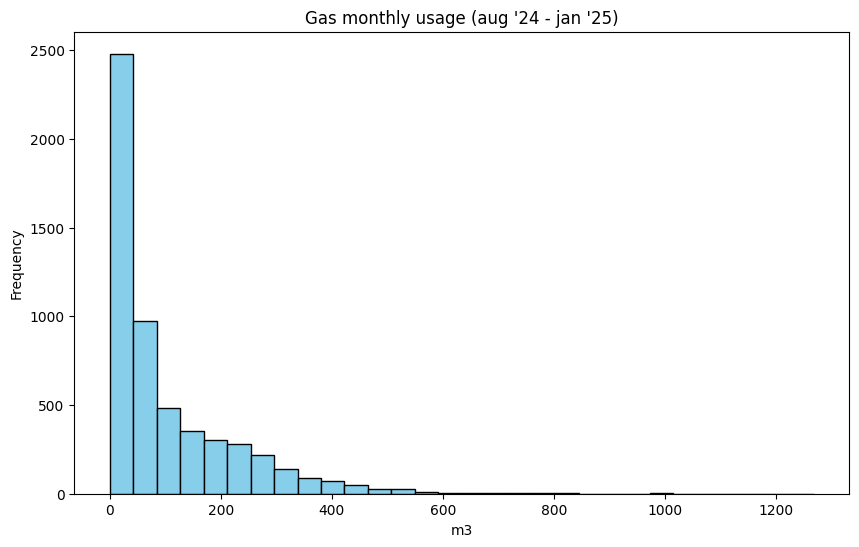

In [924]:
plt.figure(figsize=(10, 6))
plt.hist(gas['usage'], bins=30, color='skyblue', edgecolor='black')
plt.title("Gas monthly usage (aug '24 - jan '25)")
plt.xlabel('m3')
plt.ylabel('Frequency')
plt.show()

#### Total gas usage per household for the period available in the database

In [925]:
total_usage = (
    gas.groupby('household_id')['usage']
    .sum()
    .reset_index(name='total')    # Reset index and name the column
)

In [926]:
# merge with households
total_usage.rename(columns={'household_id': 'id'}, inplace=True)
house_gas = pd.merge(households, total_usage, on='id', how='left')

### 1.1 Gasloos

In [927]:
# Only looking at the Active accounts
house_gas = house_gas[house_gas['active']]

In [928]:
RELEVANT_USAGE = 30  # relavant m3 for period aug '24 - feb '25 to say 'no gas' or 'with gas'

In [929]:
# merge with households
house_gas['no_meter'] = pd.isna(house_gas['gas_ean'])
house_gas['no_usage'] = (~pd.isna(house_gas['total']) & (house_gas['date_of_activation'] < datetime(2024, 9, 1)) & (house_gas['total'] <= RELEVANT_USAGE))

In [930]:
print(f"{sum(house_gas['no_usage'])} households have a gas meter but no (significant) usage between august '24 and feb '25")

94 households have a gas meter but no (significant) usage between august '24 and feb '25


In [931]:
house_gas['gasloos'] = house_gas['no_meter'] | house_gas['no_usage']

In [934]:
per_bouwjaar = (
    house_gas.groupby('bouwjaar')[['no_usage', 'no_meter', 'gasloos']]
    .apply(lambda x: (x.sum() / len(x)) * 100)  # Calculate percentage
)

per_bouwjaar['no_usage'] = per_bouwjaar['no_usage'].round(2).astype(str) + '%'
per_bouwjaar['no_meter'] = per_bouwjaar['no_meter'].round(2).astype(str) + '%'
per_bouwjaar['gasloos'] = per_bouwjaar['gasloos'].round(2).astype(str) + '%'
per_bouwjaar

,no_usage,no_meter,gasloos
bouwjaar,,,
1950-1975,3.89%,2.48%,6.37%
1975-1992,3.24%,1.08%,4.32%
1992-2006,4.17%,0.76%,4.92%
2006-2015,5.65%,4.03%,9.68%
na 2015,2.93%,55.12%,58.05%
tot 1950,2.6%,1.73%,4.33%


In [935]:
per_postcode = (
    house_gas.groupby('postcode')[['no_usage', 'no_meter', 'gasloos']]
    .apply(lambda x: (x.sum() / len(x)) * 100)  # Calculate percentage
)
per_postcode['no_usage'] = per_postcode['no_usage'].round(2).astype(str) + '%'
per_postcode['no_meter'] = per_postcode['no_meter'].round(2).astype(str) + '%'
per_postcode['gasloos'] = per_postcode['gasloos'].round(2).astype(str) + '%'
per_postcode

,no_usage,no_meter,gasloos
postcode,,,
5591,3.5%,4.23%,7.73%
5595,3.82%,5.81%,9.63%
6029,4.8%,23.14%,27.95%


In [277]:
per_bouwjaar.to_csv('../data/gasloos_bouwjaar.csv', sep=';', index=False)
per_postcode.to_csv('../data/gasloos_postcode.csv', sep=';', index=False)

### 1.2 Inductie

In [936]:
columns = ["postcode", "bouwjaar", "gas_or_induction"]
inductie = households[columns].copy()

In [937]:
inductie['gas_or_induction'] = inductie['gas_or_induction'].replace({'Induction': 'Inductie', '': None})

In [938]:
per_bouwjaar = (
    inductie.dropna(subset=['bouwjaar', 'gas_or_induction']).pivot_table(
        index='bouwjaar',
        columns='gas_or_induction',
        aggfunc='size',
        fill_value=0
    )
)

per_bouwjaar.columns.name = '#'

# Calculate percentages
per_bouwjaar_perc = per_bouwjaar.copy().div(per_bouwjaar.sum(axis=1), axis=0) * 100

# Format percentages
for col in per_bouwjaar.columns:
    per_bouwjaar_perc[col] = per_bouwjaar_perc[col].round(2).astype(str) + '%'

per_bouwjaar_perc.columns.name = ''

In [940]:
per_bouwjaar

#,Gas,Inductie
bouwjaar,,
1950-1975,21,36
1975-1992,22,22
1992-2006,2,8
2006-2015,7,8
na 2015,2,5
tot 1950,2,6


In [942]:
per_bouwjaar_perc

,Gas,Inductie
bouwjaar,,
1950-1975,36.84%,63.16%
1975-1992,50.0%,50.0%
1992-2006,20.0%,80.0%
2006-2015,46.67%,53.33%
na 2015,28.57%,71.43%
tot 1950,25.0%,75.0%


In [943]:
per_postcode = (
    inductie.dropna(subset=['postcode', 'gas_or_induction']).pivot_table(
        index='postcode',
        columns='gas_or_induction',
        aggfunc='size',
        fill_value=0
    )
)
per_postcode.columns.name = '#'

# Calculate percentages
per_postcode_perc = per_postcode.copy().div(per_postcode.sum(axis=1), axis=0) * 100

# Format percentages
for col in per_postcode_perc.columns:
    per_postcode_perc[col] = per_postcode_perc[col].round(2).astype(str) + '%'

per_postcode_perc.columns.name = ''

In [944]:
per_postcode

#,Gas,Inductie
postcode,,
5591,39,61
5595,11,19
6029,6,5


In [945]:
per_postcode_perc

,Gas,Inductie
postcode,,
5591,39.0%,61.0%
5595,36.67%,63.33%
6029,54.55%,45.45%


### 1.3 Warmtepomp

In [946]:
columns = ["postcode", "bouwjaar", "heating_type"]
warmtepomp = households[columns].copy()

In [947]:
translations = {
    'Central heating boiler, Heat pump': 'Hybride', 
    'Heat pump': 'Warmtepomp', 
    'Heat pump, Central heating boiler': 'Hybride',
    'Heat pump, Underfloor heating': 'Warmtempomp',
    'Heat pump, Underfloor heating, Central heating boiler': 'Hybride',
    'Hybrid boiler': 'Hybride',
    'Hybrid boiler, Underfloor heating': 'Hybride',
    'Hybrid heat pump': 'Hybride',
    'Hybrid heat pump, Underfloor heating, Infrared panels': 'Hybride',
    'Hybride ketel': 'Hybride',
}
translations.update({'': None})

warmtepomp['heating_type'] = warmtepomp['heating_type'].replace(translations)

In [948]:
per_bouwjaar = (
    warmtepomp.dropna(subset=['bouwjaar', 'heating_type']).pivot_table(
        index='bouwjaar',
        columns='heating_type',
        aggfunc='size',
        fill_value=0
    )
)


per_bouwjaar.columns.name = '#'

# Calculate percentages
per_bouwjaar_perc = per_bouwjaar.copy().div(per_bouwjaar.sum(axis=1), axis=0) * 100

# Format percentages
for col in per_bouwjaar.columns:
    per_bouwjaar_perc[col] = per_bouwjaar_perc[col].round(2).astype(str) + '%'

per_bouwjaar_perc.columns.name = ''


per_bouwjaar = per_bouwjaar[["Warmtepomp", "Hybride"]]
per_bouwjaar_perc = per_bouwjaar_perc[["Warmtepomp", "Hybride"]]


In [949]:
per_bouwjaar

#,Warmtepomp,Hybride
bouwjaar,,
1950-1975,13,15
1975-1992,13,5
1992-2006,5,5
2006-2015,13,6
na 2015,68,2
tot 1950,3,5


In [950]:
per_bouwjaar_perc

,Warmtepomp,Hybride
bouwjaar,,
1950-1975,5.22%,6.02%
1975-1992,5.7%,2.19%
1992-2006,5.95%,5.95%
2006-2015,12.75%,5.88%
na 2015,62.39%,1.83%
tot 1950,3.57%,5.95%


In [951]:
per_postcode = (
    warmtepomp.dropna(subset=['postcode', 'heating_type']).pivot_table(
        index='postcode',
        columns='heating_type',
        aggfunc='size',
        fill_value=0
    )
)
per_postcode.columns.name = '#'

# Calculate percentages
per_postcode_perc = per_postcode.copy().div(per_postcode.sum(axis=1), axis=0) * 100

# Format percentages
for col in per_postcode_perc.columns:
    per_postcode_perc[col] = per_postcode_perc[col].round(2).astype(str) + '%'

per_postcode_perc.columns.name = ''


per_postcode = per_postcode[["Warmtepomp", "Hybride"]]
per_postcode_perc = per_postcode_perc[["Warmtepomp", "Hybride"]]

In [952]:
per_postcode

#,Warmtepomp,Hybride
postcode,,
5591,64,24
5595,25,9
6029,27,5


In [953]:
per_postcode_perc

,Warmtepomp,Hybride
postcode,,
5591,11.35%,4.26%
5595,12.44%,4.48%
6029,29.35%,5.43%


### Electricity

In [805]:
elec_usage_query = f"SELECT p4.query_date, p4.measurement_total, hh.id AS household_id, hh.account_status, hh.date_of_activation FROM public.p4_month_data p4 JOIN public.households hh ON hh.electricity_ean = p4.meter_ean WHERE p4.type = 'electricity' AND hh.client_id = '{HL}'"

In [806]:
elec = pd.read_sql(elec_usage_query, engine)
elec.to_csv('../data/spa_elec.csv', sep=';', decimal=',', index=False)
elec.to_csv('../../../Documents/SWA/data/spa_elec.csv', sep=';', decimal=',', index=False)

In [807]:
elec = elec[['household_id', 'account_status', 'query_date', 'measurement_total', 'date_of_activation']]  # sort columns
elec['date_of_activation'] = pd.to_datetime(elec['date_of_activation'], utc=False).dt.tz_localize(None)  # convert to dt
elec['query_date'] = pd.to_datetime(elec['query_date']).dt.to_period('M').dt.to_timestamp()  # convert to dt
elec['household_id'] = elec['household_id'].astype('str')  # convert to string
elec.sort_values(by=['household_id', 'query_date'], inplace=True)  # sort
elec.reset_index(inplace=True)

In [808]:
before = len(elec)
elec = elec[elec['account_status'] == 'Active']
print(f"Dropped {before - len(elec)} readings for inactive accounts")

Dropped 10 readings for inactive accounts


In [809]:
# Calculate usage per household
for id in elec['household_id'].unique():
    subset = elec[elec['household_id'] == id]
    elec.loc[subset.index, 'usage'] = subset['measurement_total'].diff()
    elec.loc[subset.index, 'period'] = subset['query_date'].diff()

In [810]:
# we remove extreme values
elec = elec[elec['usage'] >= 0]

In [811]:
elec_all_periods = elec.copy()

In [772]:
# assure we only look at usage for one month (the period is < 32 days
elec['month'] = elec['period'] < pd.Timedelta(days=32)
elec = elec[elec['month']]

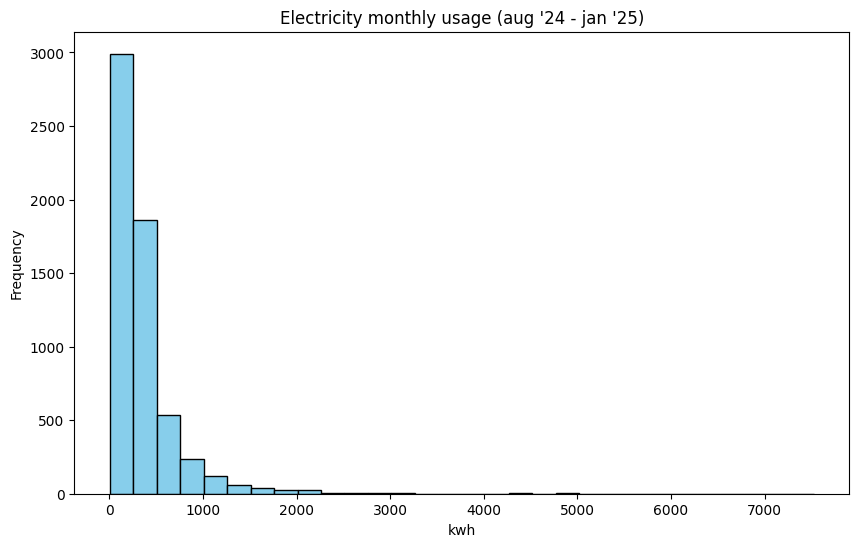

In [773]:
plt.figure(figsize=(10, 6))
plt.hist(elec['usage'], bins=30, color='skyblue', edgecolor='black')
plt.title("Electricity monthly usage (aug '24 - jan '25)")
plt.xlabel('kwh')
plt.ylabel('Frequency')
plt.show()

### Gas + Electricity

In [954]:
energy = pd.merge(gas_all_periods, elec_all_periods[['household_id', 'query_date', 'usage']], on=['household_id', 'query_date'], how='outer', suffixes=['gas', 'elec'])
energy['usagegas'] = energy['usagegas'].fillna(0)
energy['energy'] = energy['usageelec'] + energy['usagegas'] * 9.77
energy['query_date'] = pd.to_datetime(energy['query_date']).dt.to_period('M').dt.to_timestamp()  # convert to dt

In [957]:
energy

,index,household_id,account_status,query_date,measurement_total,date_of_activation,usagegas,period,usageelec,energy
0,1.0,0034b1f4-64c4-434e-af78-7246829c9b42,Active,2024-09-01,5556.401,2021-10-30,9.655,31 days,248.812,343.14135
1,2.0,0034b1f4-64c4-434e-af78-7246829c9b42,Active,2024-10-01,5635.670,2021-10-30,79.269,30 days,289.769,1064.22713
2,3.0,0034b1f4-64c4-434e-af78-7246829c9b42,Active,2024-12-01,6070.714,2021-10-30,435.044,61 days,548.857,4799.23688
3,4.0,0034b1f4-64c4-434e-af78-7246829c9b42,Active,2025-01-01,6362.141,2021-10-30,291.427,31 days,234.458,3081.69979
4,6.0,003a7b4d-492b-4d35-aded-f91321383a0a,Active,2024-09-01,6053.608,2021-09-30,27.820,31 days,157.258,429.05940
...,...,...,...,...,...,...,...,...,...,...
8207,9555.0,ffdbe458-d2f3-4e0e-949c-acd95465862d,Active,2025-01-01,14508.736,2022-12-24,257.979,31 days,183.000,2703.45483
8208,9557.0,ffde8789-ae9b-415a-af1a-06cc5e234640,Active,2024-09-01,10612.230,2021-10-28,8.876,31 days,147.809,234.52752
8209,9558.0,ffde8789-ae9b-415a-af1a-06cc5e234640,Active,2024-10-01,10636.515,2021-10-28,24.285,30 days,234.557,471.82145
8210,9559.0,ffde8789-ae9b-415a-af1a-06cc5e234640,Active,2024-12-01,10953.594,2021-10-28,317.079,61 days,1071.073,4168.93483


In [958]:
energy_pivoted = energy.pivot(index='household_id', columns='query_date', values='energy')
gas_pivoted = energy.pivot(index='household_id', columns='query_date', values='usagegas')
elec_pivoted = energy.pivot(index='household_id', columns='query_date', values='usageelec')
energy_pivoted.sample(2)

query_date,2024-09-01,2024-10-01,2024-12-01,2025-01-01
household_id,,,,
c7dd6dce-a768-48a2-bb32-c14430e3c74b,794.73979,1768.50966,8452.53209,5192.14808
c349209e-7906-468c-a439-c2c85a79f62a,234.76784,455.32202,550.91700,3222.93054


In [959]:
energy_pivoted.to_csv('../data/spa_energy_pivoted.csv', sep=';', decimal=',')
gas_pivoted.to_csv('../data/spa_gas_pivoted.csv', sep=';', decimal=',')
elec_pivoted.to_csv('../data/spa_elec_pivoted.csv', sep=';', decimal=',')